FORKED from 07-TFM-CarDrawing-FirstAprox-Unet-segment-mask

**PARTIMOS DEL KERNEL 07 INTENTAMOS AUGMENTACION EXTERNA**
Referencia-->https://github.com/albu/albumentations

En el Notebook 08 hemos detectado que aplicando la mascara entrenada en el Carvana no produce resultados muy buenos en el dataset de Standford.

En el primero intento de entrenar la mascara NO hemos usado augmentación, así que vamos a repetir el noteboob 07 (train segmentation mask) aplicando augmentación con el objetivo de mejorar el modelo


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import os
from skimage.transform import resize
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.io import imread, imshow #, concatenate_images
import PIL 
from PIL import Image
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

['manualdraw', 'carvana-image-masking-challenge', 'stanford-car-dataset-by-classes-folder']


Using TensorFlow backend.


Preparamos unas cuantas funciones para leer del directorio

In [2]:
!pip install albumentations > /dev/null

In [3]:
def files_names_in_path(path="",extension=".jpg"):
    files = []
    masks = []
    for f in os.listdir(path):
        filename, file_extension = os.path.splitext(f)
        if file_extension == '.gif':
            files.append(filename.replace('_mask','')+".jpg")
            masks.append(filename+"_mask.gif")
            
    return files, masks
car_path = '../input/carvana-image-masking-challenge/train/'
mask_path = '../input/carvana-image-masking-challenge/train_masks/'
input_files,input_masks = files_names_in_path(mask_path)

print(input_files[0:5])


['4b74275babf7_02.jpg', '3071362591f7_04.jpg', '0495dcf27283_10.jpg', 'd1a3af34e674_01.jpg', 'fc237174b128_09.jpg']


[[[0.94901961 0.95294118 0.93333333]
  [0.94901961 0.95294118 0.93333333]
  [0.94901961 0.95294118 0.93333333]
  ...
  [0.94901961 0.94901961 0.94901961]
  [0.94901961 0.94901961 0.94901961]
  [0.94901961 0.94901961 0.94901961]]

 [[0.94901961 0.95294118 0.93333333]
  [0.94901961 0.95294118 0.93333333]
  [0.94901961 0.95294118 0.93333333]
  ...
  [0.94901961 0.94901961 0.94901961]
  [0.94901961 0.94901961 0.94901961]
  [0.94901961 0.94901961 0.94901961]]

 [[0.94901961 0.95294118 0.93333333]
  [0.94901961 0.95294118 0.93333333]
  [0.94901961 0.95294118 0.93333333]
  ...
  [0.94901961 0.94901961 0.94901961]
  [0.94901961 0.94901961 0.94901961]
  [0.94901961 0.94901961 0.94901961]]

 ...

 [[0.68235294 0.69803922 0.70980392]
  [0.68235294 0.69803922 0.70980392]
  [0.68235294 0.69803922 0.70980392]
  ...
  [0.69019608 0.70588235 0.71764706]
  [0.69019608 0.70588235 0.71764706]
  [0.69019608 0.70588235 0.71764706]]

 [[0.68235294 0.69803922 0.70980392]
  [0.68235294 0.69803922 0.70980392]


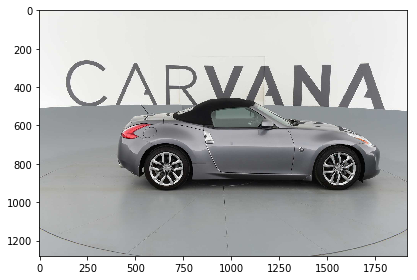

In [4]:
def load_image_and_normalize_and_resize(file_path="",normalize=True):
    if normalize:
        return (imread(file_path)/255)
    else:
        return (imread(file_path))
    

print(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]))
print(imshow(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,2)[0])))
print(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape)
HEIGH = load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape[0]
WIDTH = load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape[1]

In [5]:
mask = pd.read_csv('../input/carvana-image-masking-challenge/train_masks.csv')

In [6]:
len(mask)

5088

In [7]:
# empezamos a trabajar para obtener la mascara del coche solo nos interesa el coche para mejorar el performanc
# ademas queremos simular los trazos humanos extrayendo los edges del coche (pero solo del coche, el fondo no nos interesa)
import cv2
indx=5000
carimage = car_path+input_files[indx]
maskimage = mask_path+input_files[indx].replace('.jpg','_mask.gif')

print(carimage)
print(maskimage)
img = cv2.imread(carimage)
#mask = cv2.imread(maskimage)
mask=imread(maskimage)
print(mask)



../input/carvana-image-masking-challenge/train/fff9b3a5373f_12.jpg
../input/carvana-image-masking-challenge/train_masks/fff9b3a5373f_12_mask.gif
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


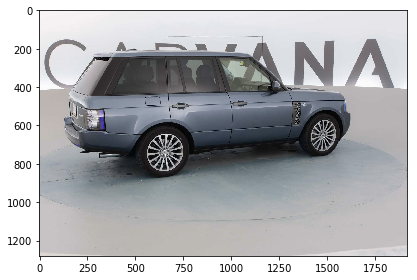

In [8]:
#La imagen original
imshow(img)

(1280, 1918)


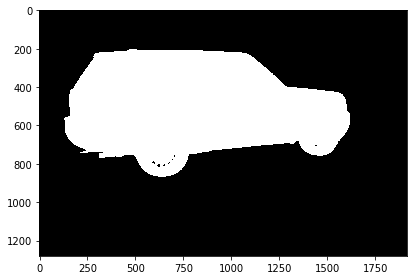

In [9]:
#La mascara
print(mask.shape)
imshow(mask)

In [10]:
H = 256
W = 256

def downsample(img, h, w):    
    ret = resize(img, (h, w), mode='constant', preserve_range=True)
    # plt.imshow(ret)
    return ret
    #return cv2.resize(img, (h, w))

In [11]:


from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)





aug = Compose([
    OneOf([RandomSizedCrop(min_max_height=(int(H/2), H), height=H, width=W, p=0.5),
          PadIfNeeded(min_height=H, min_width=W, p=0.5)], p=1),    
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
        ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5),
        OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8),
    RandomBrightnessContrast(p=0.8),    
    RandomGamma(p=0.8)])

tmp_img = downsample(img/255,H,W)
tmp_mask = downsample(mask/255,H,W)
A = aug(image=tmp_img,mask=tmp_mask)

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [12]:
A['mask'].shape


(256, 256)

In [13]:
# nos definimos funcion de plot facil...
def plot_tuple(orig, augmented, orig_mask, augmented_mask):
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
    
    ax1[0].imshow(orig, cmap='gray')
    ax1[1].imshow(augmented, cmap='gray')
    ax2[0].imshow(orig_mask, cmap='gray')
    ax2[1].imshow(augmented_mask, cmap='gray')
    
    plt.tight_layout()

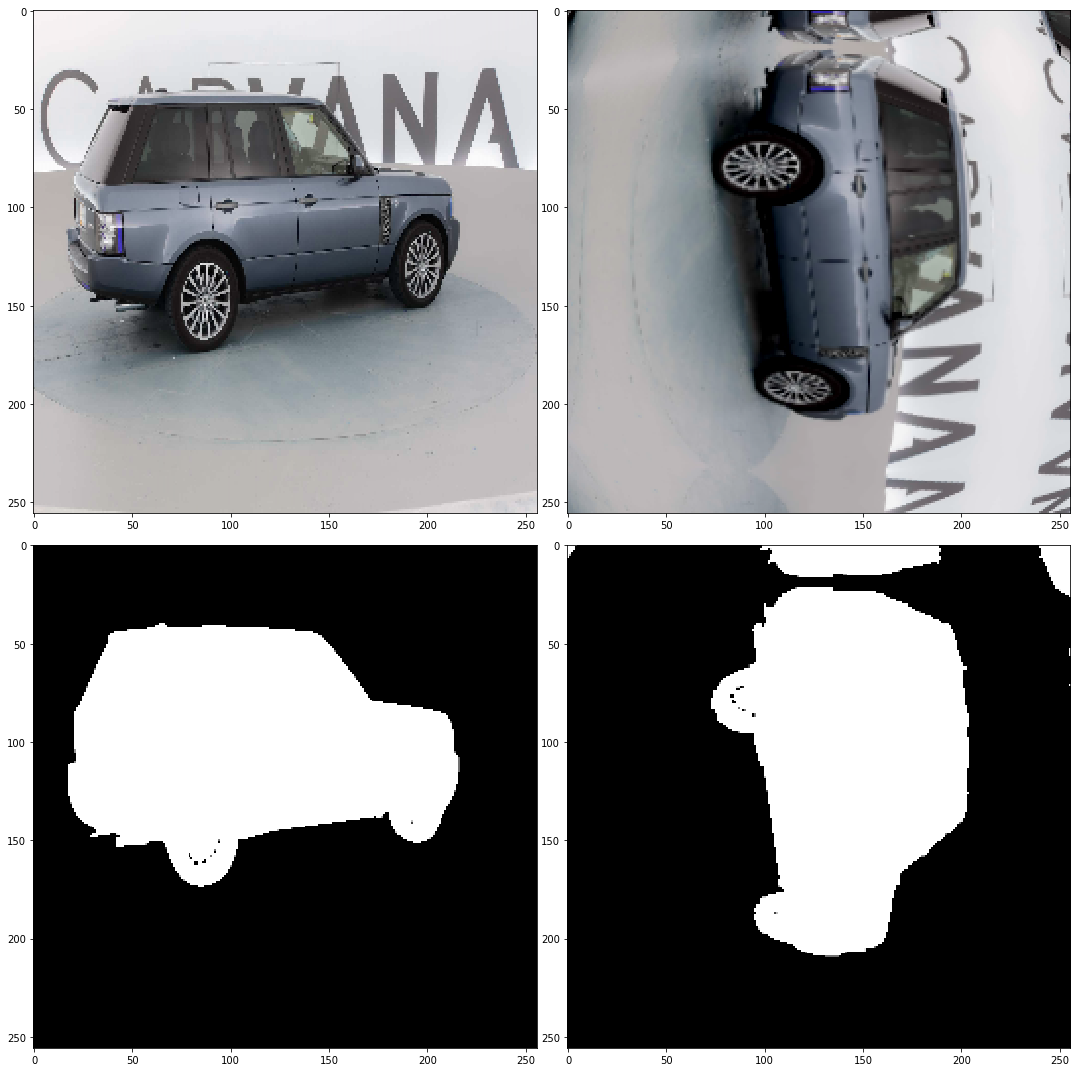

In [14]:
plot_tuple(tmp_img, A['image'],tmp_mask,A['mask'].reshape(H,W))

In [15]:
from sklearn.model_selection import train_test_split
train_input, test_input, _, _ = train_test_split(input_files, input_files, test_size=0.15, random_state=42)
print(len(train_input))
print(len(test_input))

4324
764


In [16]:
H = 256
W = 256
BATCH_SIZE=32


def generator_resize(path, batch_size, h, w):
    
    while True:
        input_img=[]
        output_mask=[]
        for x in range(batch_size):
            selected = np.squeeze(np.random.choice(path,1))
            carimage = car_path+str(selected)
            maskimage = mask_path+str(selected).replace('.jpg','_mask.gif')
            
            img = imread(carimage)
            mask = imread(maskimage)
            img = downsample(img/255, h, w)
            mask = downsample(mask/255, h, w)
            
            # input_img.append(img)
            # output_mask.append(mask.reshape(H,W,1))
            
            AUG = aug(image=img, mask = mask)
            input_img.append(AUG['image'])
            output_mask.append(AUG['mask'].reshape(h,w,1))
            
        yield np.array(input_img), np.array(output_mask)
        
imgs,masks=next(generator_resize(train_input,5, H, W))
print(imgs.shape)
print(masks.shape)
print(np.max(imgs))
print(np.max(masks))

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(5, 256, 256, 3)
(5, 256, 256, 1)
1.0
1.0


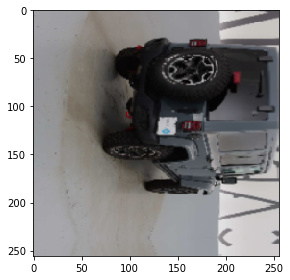

In [17]:
imshow(imgs[3])

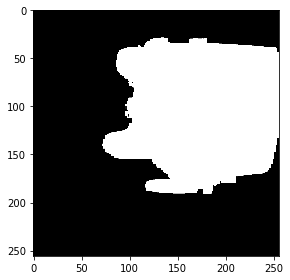

In [18]:
imshow(masks[3].reshape(H,W))

In [19]:
#Vamos a entrenar nuestra Unet classica salidas sigmoid y binarycrossentropy

In [20]:
#Based on my custom old experiments with U-Net
#https://github.com/nopaixx/Py-Models/blob/master/MODEL02-Tensoflow%20Keras%20Unet%20Image%20segmentation.ipynb

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model
input_img = Input((H, W, 3), name='img')
model = get_unet(input_img, n_filters=32, dropout=0.5, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activat

In [21]:
#definimos nuestro callback para guardar
saver = ModelCheckpoint('unet-carvana-augmented.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [22]:
histo = model.fit_generator(generator_resize(train_input,BATCH_SIZE, H, W),steps_per_epoch=10, epochs=40,
                    validation_data=generator_resize(test_input,BATCH_SIZE, H, W),validation_steps=10,
                    callbacks=[saver])

Instructions for updating:
Use tf.cast instead.
Epoch 1/40


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 147s 15s/step - loss: 0.5974 - acc: 0.7162 - val_loss: 0.6944 - val_acc: 0.7882
Epoch 2/40
10/10 [==============================] - 129s 13s/step - loss: 0.4062 - acc: 0.8510 - val_loss: 0.4166 - val_acc: 0.8280
Epoch 3/40
10/10 [==============================] - 140s 14s/step - loss: 0.3482 - acc: 0.8655 - val_loss: 0.4610 - val_acc: 0.8563
Epoch 4/40
10/10 [==============================] - 137s 14s/step - loss: 0.3297 - acc: 0.8613 - val_loss: 0.3756 - val_acc: 0.8573
Epoch 5/40
10/10 [==============================] - 135s 14s/step - loss: 0.2858 - acc: 0.8834 - val_loss: 0.5635 - val_acc: 0.8176
Epoch 6/40
10/10 [==============================] - 140s 14s/step - loss: 0.2594 - acc: 0.8983 - val_loss: 0.9245 - val_acc: 0.7368
Epoch 7/40
10/10 [==============================] - 141s 14s/step - loss: 0.2202 - acc: 0.9187 - val_loss: 0.8457 - val_acc: 0.7533
Epoch 8/40
10/10 [==============================] - 143s 14s/step - loss: 0.2381 - acc:

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


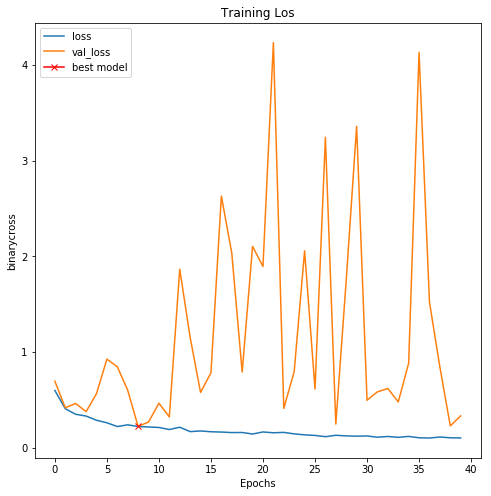

In [23]:

plt.figure(figsize=(8, 8))
plt.title("Training Los")
plt.plot(histo.history["loss"], label="loss")
plt.plot(histo.history["val_loss"], label="val_loss")
plt.plot( np.argmin(histo.history["val_loss"]), np.min(histo.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("binarycross")
plt.legend();

In [24]:
!ls

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


__notebook__.ipynb  __output__.json  unet-carvana-augmented.hdf5


In [25]:
inp,out=next(generator_resize(test_input,BATCH_SIZE, H, W))

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [26]:
pred = model.predict(inp)

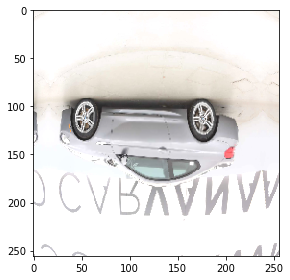

In [27]:
imshow(inp[0])

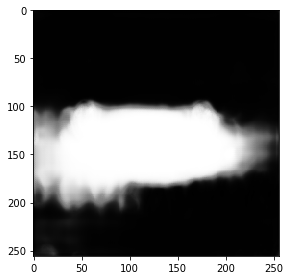

In [28]:
imshow(pred[0].reshape(H,W))

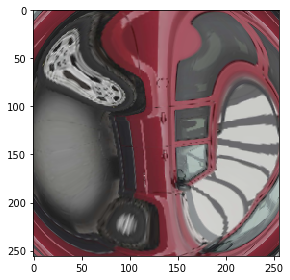

In [29]:
imshow(inp[1])

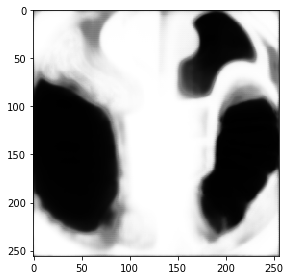

In [30]:
imshow(pred[1].reshape(H,W))

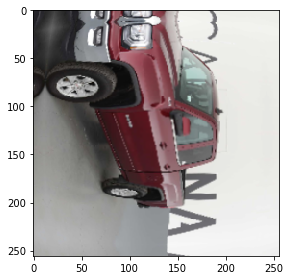

In [31]:
imshow(inp[2])

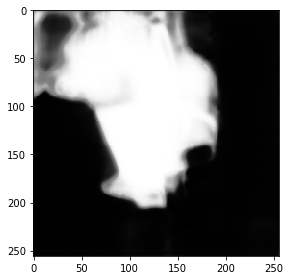

In [32]:
imshow(pred[2].reshape(H,W))

8144


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(30, 256, 256, 3)
[[[[0.70655637 0.75753676 0.64221814]
   [0.58286994 0.61816406 0.506767  ]
   [0.69730009 0.72867264 0.63847656]
   ...
   [0.65860524 0.67036994 0.63507583]
   [0.65490196 0.65882353 0.62745098]
   [0.64430147 0.64822304 0.61685049]]

  [[0.50055147 0.53192402 0.44957108]
   [0.50146293 0.51322763 0.43871783]
   [0.51045879 0.5222235  0.45555683]
   ...
   [0.6620098  0.67377451 0.63848039]
   [0.65882353 0.6627451  0.63137255]
   [0.64491422 0.64883578 0.61746324]]

  [[0.63484988 0.66622243 0.57431066]
   [0.49127221 0.49911535 0.44690947]
   [0.45856694 0.47033165 0.40366498]
   ...
   [0.6702091  0.67413067 0.64275812]
   [0.66603477 0.66995634 0.64642693]
   [0.66053922 0.66446078 0.64093137]]

  ...

  [[0.57052696 0.56660539 0.54699755]
   [0.6        0.59607843 0.57647059]
   [0.62125077 0.60948606 0.58203508]
   ...
   [0.53535539 0.53535539 0.49613971]
   [0.53143382 0.53143382 0.49221814]
   [0.52720588 0.52720588 0.4879902 ]]

  [[0.5784352  0.57451363 0

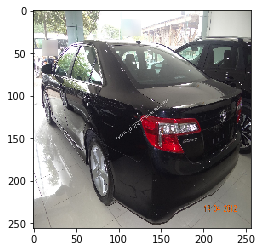

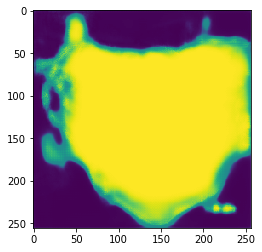

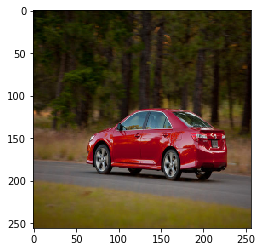

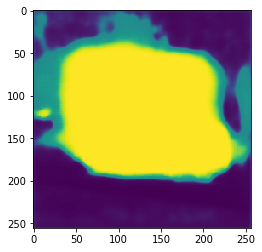

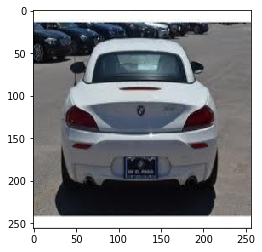

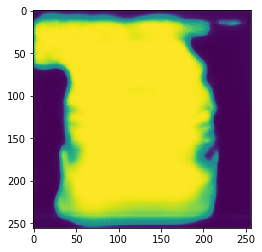

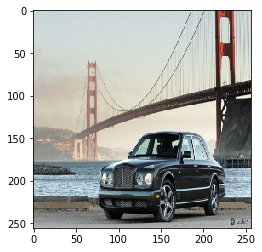

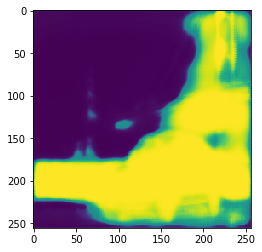

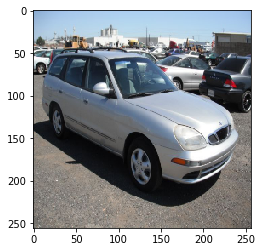

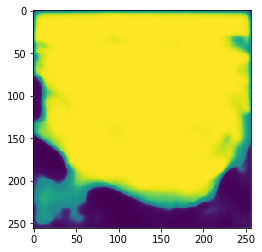

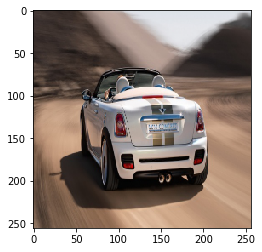

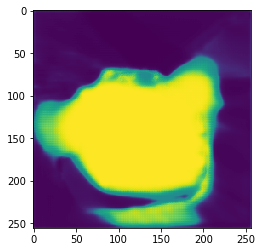

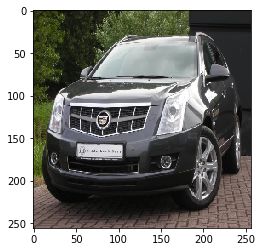

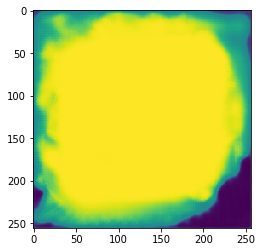

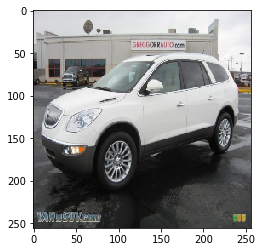

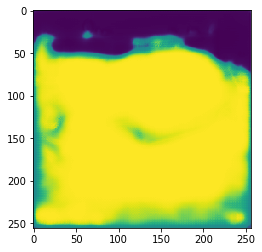

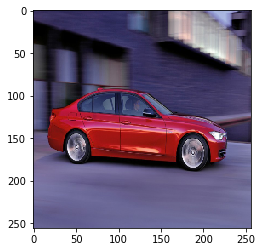

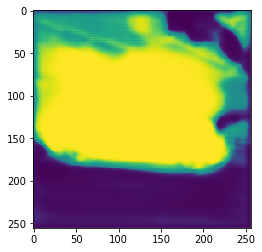

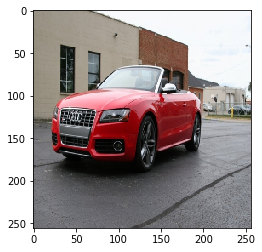

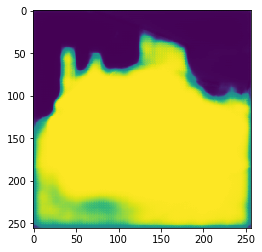

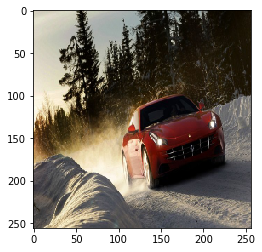

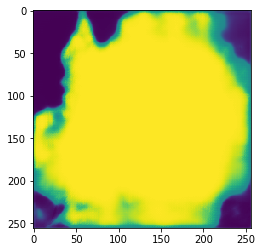

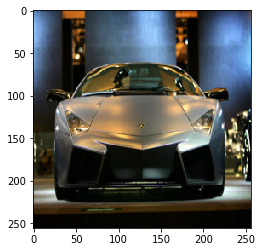

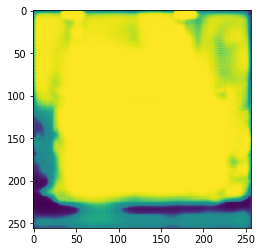

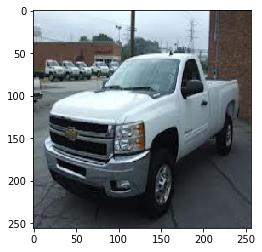

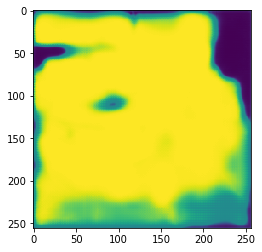

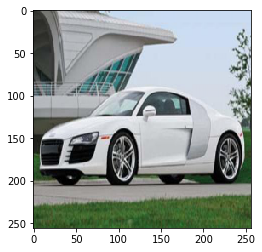

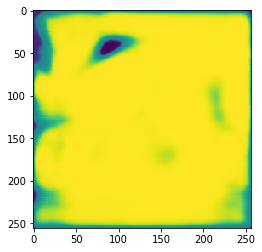

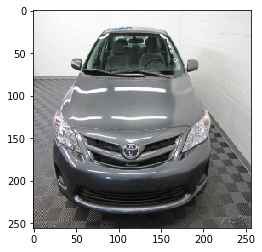

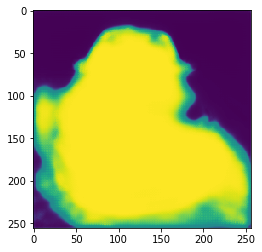

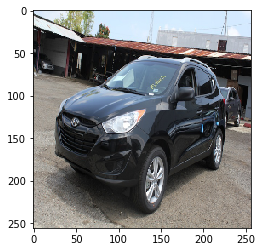

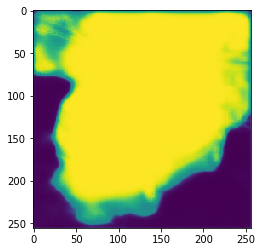

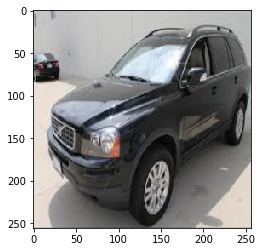

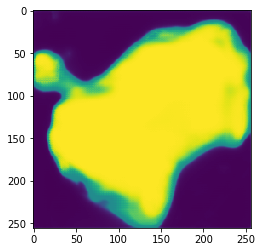

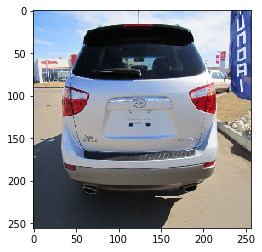

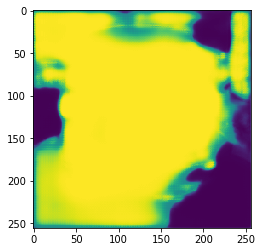

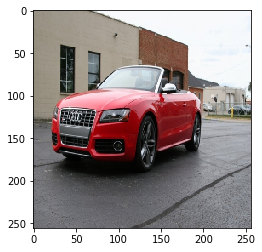

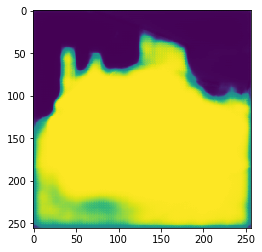

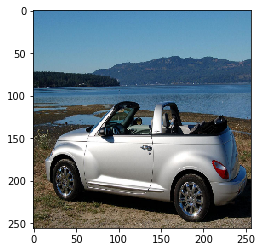

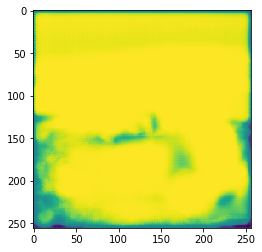

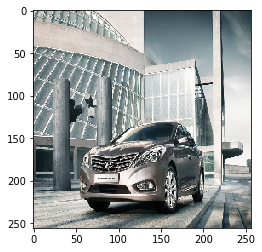

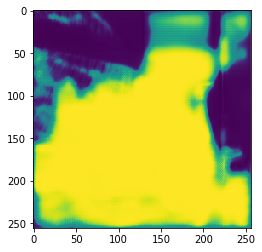

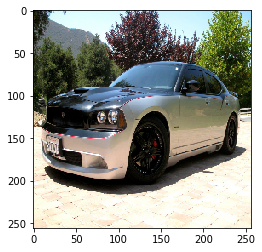

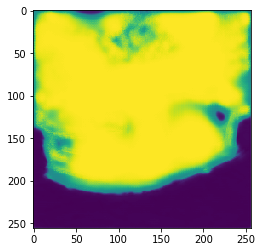

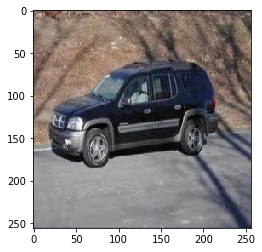

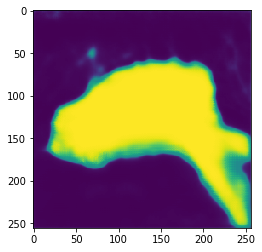

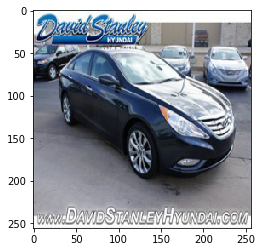

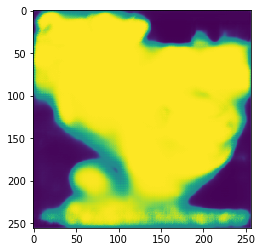

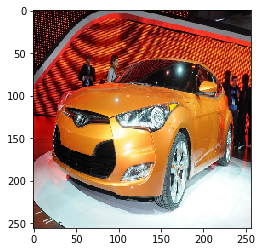

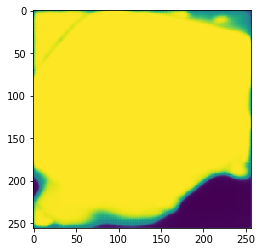

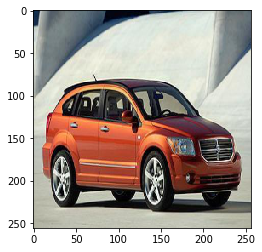

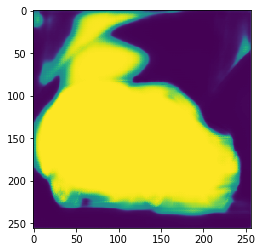

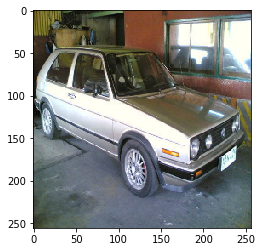

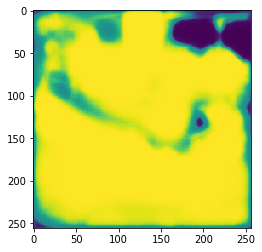

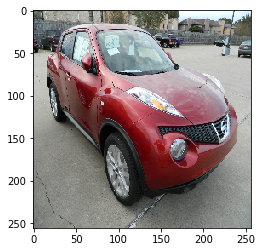

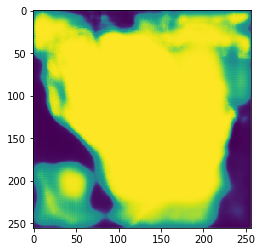

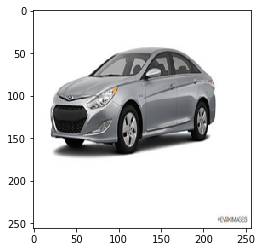

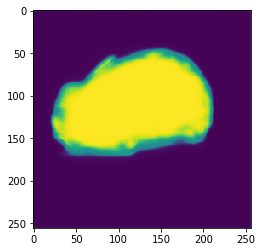

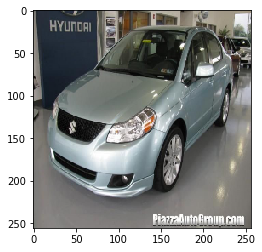

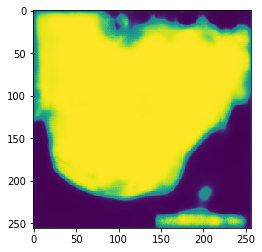

In [33]:
from keras.models import load_model


model2 = load_model('unet-carvana-augmented.hdf5')

standfordcars = '../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train'

images=[]
for x in os.listdir(standfordcars):
    for image in os.listdir(standfordcars+'/'+str(x)):
        images.append(standfordcars+'/'+str(x)+'/'+image)
        
print(len(images))
images[0:5]

# Vamos a hacer print de unas 30 imagenes random
randomimg = np.random.choice(images,30)
randomimg
#Leemos las images y les hacemos el resize al final tenemos un numpy con 30 images,256,256,3
input_arr = []
for img in randomimg:
    input_arr.append(downsample(imread(img)/255,H,W))
    
input_arr = np.array(input_arr)
print(input_arr.shape)
print(input_arr)
#Predecimos la mascara
preds = model2.predict(input_arr)
print(preds.shape)
import matplotlib.pyplot as plt
%matplotlib inline

for img, pred in zip(input_arr, preds):
    plt.imshow((img))
    plt.show()
    plt.imshow((pred.reshape(H,W)))
    plt.show()